# Analyse des données

Importation des modules

In [254]:
import pandas as pd  
import numpy as np, pandas as pd, matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import mannwhitneyu, norm
import chardet
import unicodedata



## Importation des bases de données

In [255]:

base_finale= pd.read_csv("base_finale.csv", delimiter=",", low_memory=False)

### Analyse de la base

In [256]:
base_finale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126073 entries, 0 to 126072
Data columns (total 41 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   126073 non-null  int64  
 1   Num_Acc      126073 non-null  int64  
 2   id_vehicule  126073 non-null  object 
 3   num_veh      126073 non-null  object 
 4   place        126073 non-null  int64  
 5   catu         126073 non-null  int64  
 6   grav         126073 non-null  int64  
 7   sexe         126073 non-null  int64  
 8   an_nais      126073 non-null  float64
 9   trajet       126073 non-null  int64  
 10  secu1        126073 non-null  int64  
 11  secu2        126073 non-null  int64  
 12  secu3        126073 non-null  int64  
 13  locp         126073 non-null  int64  
 14  actp         126073 non-null  object 
 15  etatp        126073 non-null  int64  
 16  senc         126073 non-null  int64  
 17  catv         126073 non-null  int64  
 18  obs          126073 non-

### Statistiques descriptives par accident

In [257]:
# Nombre d'usagers (potentiellement victimes ou indemnes) par accident
victimes_par_accident = base_finale.groupby("Num_Acc").size().reset_index(name='nb_usagers')
victimes_par_accident

,Num_Acc,nb_usagers
0,202100000001,2
1,202100000002,2
2,202100000003,2
3,202100000004,2
4,202100000005,1
...,...,...
56514,202100056517,1
56515,202100056518,2
56516,202100056519,1
56517,202100056520,1


Distribution du nombre d'usagers par accident

<Axes: ylabel='Count'>

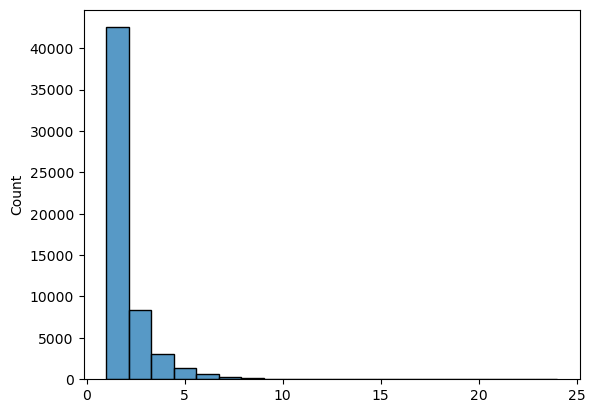

In [258]:
sns.histplot(base_finale.groupby("Num_Acc").size(), bins=20)

Le graphe montre clairement une distribution très asymétrique à droite (skewed right) du nombre d’usagers par accident :
* La majorité des accidents impliquent un seul usager.
* Un nombre décroissant d'accidents implique 2, 3, 4… usagers.
* Quelques cas rares avec plus de 10 usagers (jusqu’à 24 selon l’axe)

Comparons la distribution de la gravité (grav) en fonction du nombre d’usagers par accident.

In [259]:
# Moyenne du nombre d'usagers impliqués par accident
moyenne_usagers = victimes_par_accident['nb_usagers'].mean()
print(f"Nombre moyen d'usagers par accident : {moyenne_usagers:.2f}")


Nombre moyen d'usagers par accident : 2.23


In [260]:
# Pourcentage de chaque niveau de gravité (1: indemne, 2: tué, 3: blessé hospitalisé, 4: blessé léger)
gravite_proportions = base_finale['grav'].value_counts(normalize=True).sort_index() * 100
print("Répartition (%) des gravités :\n", gravite_proportions)


Répartition (%) des gravités :
 grav
1    41.322884
2     2.552489
3    15.134882
4    40.989744
Name: proportion, dtype: float64


### Analyse croisée usager–gravité

Cartégorisons les groupes

In [261]:
def categoriser_nb_usagers(n):
    if n == 1:
        return "1 usager"
    elif n <= 3:
        return "2-3 usagers"
    elif n <= 5:
        return "4-5 usagers"
    else:
        return "6+ usagers"

base_finale["cat_nb_usagers"] = base_finale["nb_usagers"].apply(categoriser_nb_usagers)


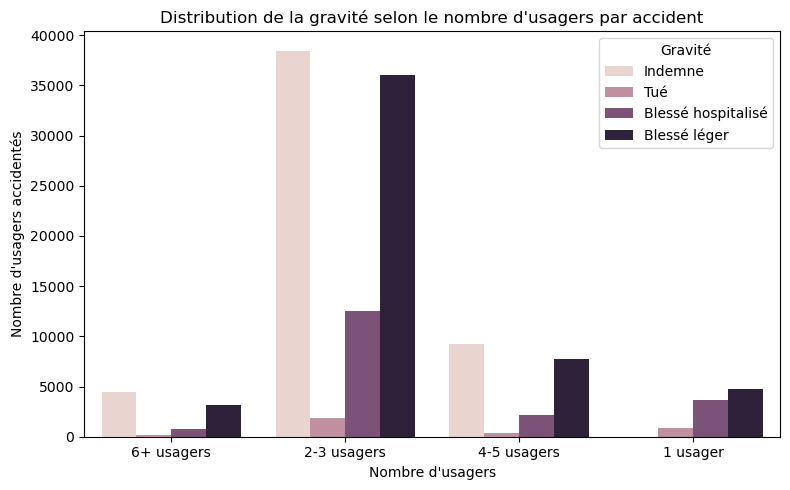

In [262]:
plt.figure(figsize=(8, 5))
sns.countplot(data=base_finale, x="cat_nb_usagers", hue="grav")
plt.title("Distribution de la gravité selon le nombre d'usagers par accident")
plt.xlabel("Nombre d'usagers")
plt.ylabel("Nombre d'usagers accidentés")
plt.legend(title="Gravité", labels=["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"])
plt.tight_layout()
plt.show()


* Les accidents avec 2-3 usagers représentent la majorité des cas et contiennent le plus de blessés légers et hospitalisés.
* Les accidents avec 1 usager, Bien présents mais avec peu de blessés graves comparativement au premier. Ces accidents sont souvent moins graves en moyenne.
* Accidents avec ≥6 usagers : Rares mais avec une proportion non négligeable de blessés hospitalisés.

In [263]:
# Analysons le taux de gravité par catégorie
base_finale["victime_grave"] = base_finale["grav"].isin([2, 3])  # 2 = tué, 3 = blessé hospitalisé
taux_gravite = base_finale.groupby("cat_nb_usagers")["victime_grave"].mean()


In [264]:
## Représentation en pourcentage pour chaque catégorie de gravité
distribution = base_finale.groupby(["cat_nb_usagers", "grav"]).size().reset_index(name='count')
distribution_total = distribution.groupby("cat_nb_usagers")["count"].transform('sum')
distribution["pourcentage"] = distribution["count"] / distribution_total * 100


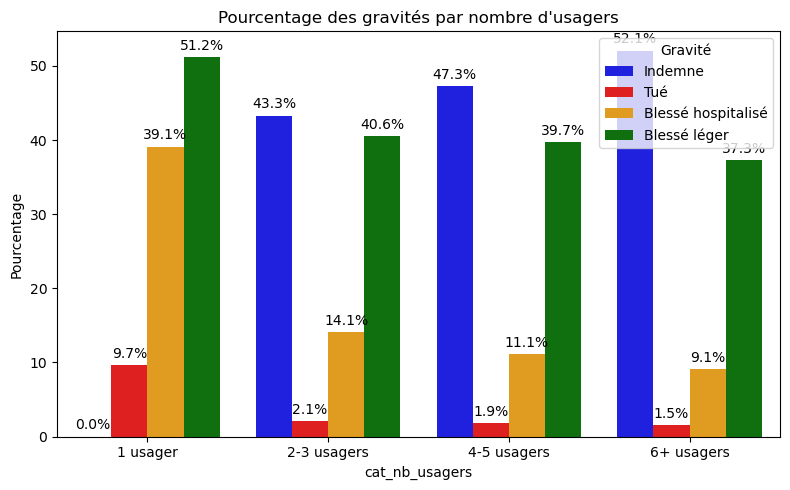

In [265]:
# Création du graphique
# Conversion des valeurs numériques de "grav" en libellés textuels
distribution["grav_cat"] = distribution["grav"].map({
    1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"})

# Définir la palette avec les libellés
palette = {"Indemne": "blue", "Tué": "red", "Blessé hospitalisé": "orange", "Blessé léger": "green"}

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=distribution, x="cat_nb_usagers", y="pourcentage", hue="grav_cat", palette=palette)

# Ajout des labels sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)

# Récupérer les légendes automatiquement des couleurs du graphique
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"], title="Gravité")

# Personnalisation du graphique
plt.ylabel("Pourcentage")
plt.title("Pourcentage des gravités par nombre d'usagers")
plt.tight_layout()
plt.show()

### Analyse croisée usager–âge-accident

In [266]:
# Analyse de l’âge
base_finale.groupby("cat_nb_usagers")["age"].mean()


cat_nb_usagers
1 usager       38.430403
2-3 usagers    39.308121
4-5 usagers    33.862545
6+ usagers     31.911678
Name: age, dtype: float64

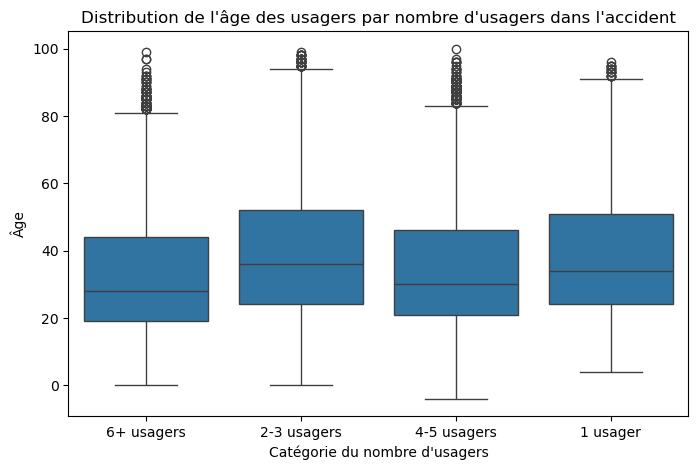

In [267]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=base_finale, x="cat_nb_usagers", y="age")
plt.title("Distribution de l'âge des usagers par nombre d'usagers dans l'accident")
plt.ylabel("Âge")
plt.xlabel("Catégorie du nombre d'usagers")
plt.show()


### Analyse croisée usager–sexe-accident

In [268]:
base_finale["sexe"].value_counts()

sexe
1    86185
2    39888
Name: count, dtype: int64

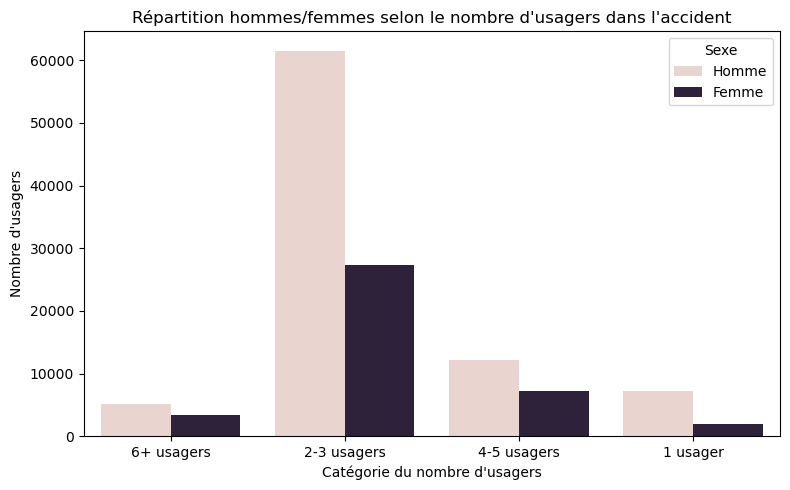

In [269]:
plt.figure(figsize=(8, 5))
sns.countplot(data=base_finale, x="cat_nb_usagers", hue="sexe")
plt.title("Répartition hommes/femmes selon le nombre d'usagers dans l'accident")
plt.xlabel("Catégorie du nombre d'usagers")
plt.ylabel("Nombre d'usagers")
plt.legend(title="Sexe", labels=["Homme", "Femme"])
plt.tight_layout()
plt.show()


### Analyse croisée usager–véhicule

Profil des victimes selon le type de véhicule (catv)

In [270]:
base_finale["catv_group"].value_counts()

catv_group
VL                  79301
Vélo / Cyclo        14992
Moto / Scooter      14011
VU                   8529
PL                   2309
EDP à moteur         1700
Transport            1341
3 roues motorisé      735
Tracteur routier      719
VAE                   578
Autre véhicule        526
Spécial               427
Train / Tram          263
Quad                  252
EDP sans moteur       252
Indéterminé           136
-1                      2
Name: count, dtype: int64

In [271]:
# Comptage des victimes par type de véhicule
profil_vehicule = base_finale.groupby('catv_group')['grav'].value_counts().unstack().fillna(0)
profil_vehicule.columns = ['Indemne', 'Tué', 'Blessé hospitalisé', 'Blessé léger']
profil_vehicule = profil_vehicule.astype(int)
print(profil_vehicule.head())


                  Indemne  Tué  Blessé hospitalisé  Blessé léger
catv_group                                                      
-1                      1    0                   1             0
3 roues motorisé      106   15                 124           490
Autre véhicule        214    2                  84           226
EDP sans moteur        12    3                  38           199
EDP à moteur          176   27                 230          1267


### Gravité selon le sexe et l'âge

Gravité par Sexe (%):
                     Masculin  Féminin
grav                                 
Indemne                71.32    28.68
Tué                    78.31    21.69
Blessé hospitalisé     71.47    28.53
Blessé léger           63.61    36.39


<Figure size 800x500 with 0 Axes>

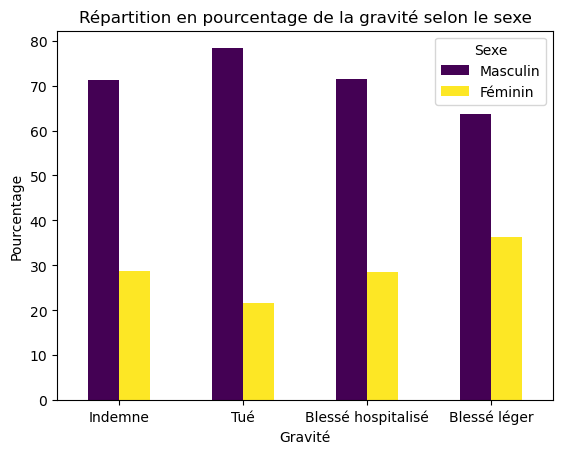

In [272]:
# Définition des labels de gravité
labels_grav = {1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"}

# Création du tableau croisé entre gravité et sexe (en %)
cross_grav_sexe = pd.crosstab(base_finale['grav'], base_finale['sexe'], normalize='index') * 100
cross_grav_sexe.columns = ['Masculin', 'Féminin']

# Ajout des labels de gravité
cross_grav_sexe.index = cross_grav_sexe.index.map(labels_grav)

print("Gravité par Sexe (%):\n", cross_grav_sexe.round(2))

# Création du graphique avec Seaborn
plt.figure(figsize=(8, 5))
cross_grav_sexe.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon le sexe")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Sexe")
plt.xticks(rotation=0)  # Pour une meilleure lisibilité des labels

plt.show()


Âge moyen par gravité :
                  grav    age
0             Indemne  39.28
1                 Tué  46.42
2  Blessé hospitalisé  39.46
3        Blessé léger  35.41


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_16832\4184102401.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_moyen_par_gravite, x='grav', y='age', palette='viridis')


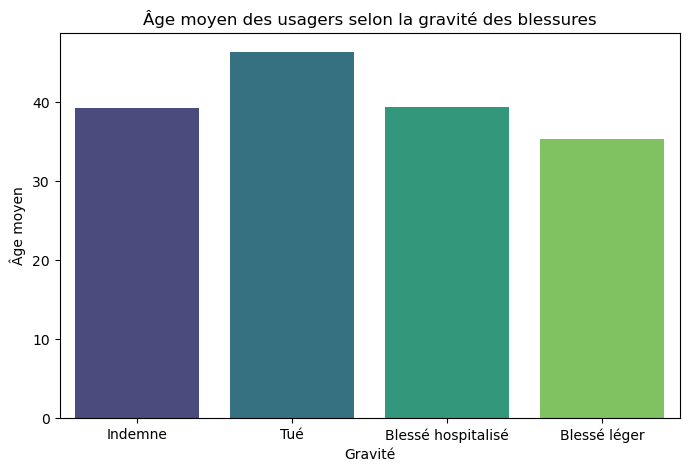

In [273]:

# Calcul de l'âge moyen par gravité
age_moyen_par_gravite = base_finale.groupby('grav')['age'].mean().reset_index()
labels_grav = {1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"}
age_moyen_par_gravite['grav'] = age_moyen_par_gravite['grav'].map(labels_grav)

print("Âge moyen par gravité :\n", age_moyen_par_gravite.round(2))

# Création du graphique
plt.figure(figsize=(8, 5))
sns.barplot(data=age_moyen_par_gravite, x='grav', y='age', palette='viridis')

plt.title("Âge moyen des usagers selon la gravité des blessures")
plt.xlabel("Gravité")
plt.ylabel("Âge moyen")
plt.xticks(rotation=0)  # Meilleure lisibilité des catégories
plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_16832\2060480.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_heure.index, y=accidents_par_heure.values, palette="viridis")


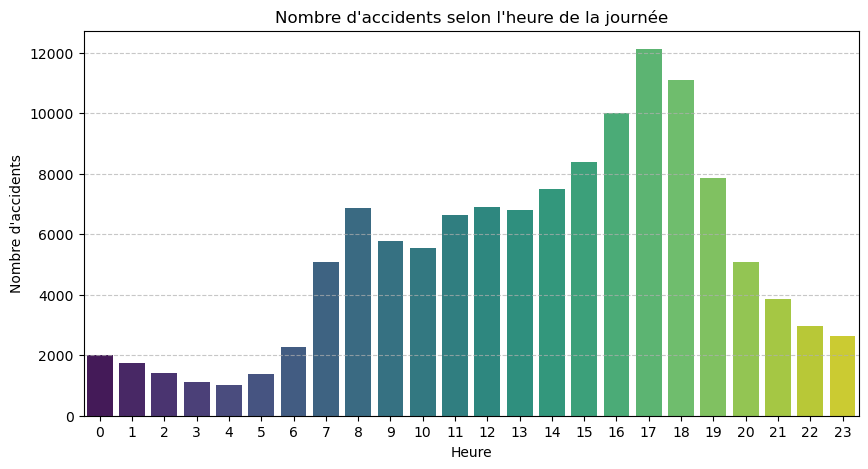

In [274]:
# Extraire l'heure uniquement si hrmn est bien formatée (ex: '1530' → 15)
base_finale['heure'] = base_finale['hrmn'].astype(str).str.zfill(4).str[:2].astype(int)

# Comptage des accidents par heure
accidents_par_heure = base_finale['heure'].value_counts().sort_index()
#print("Nombre d'accidents par heure :\n", accidents_par_heure)

# Création du graphique
plt.figure(figsize=(10, 5))
sns.barplot(x=accidents_par_heure.index, y=accidents_par_heure.values, palette="viridis")

plt.title("Nombre d'accidents selon l'heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=0)  # Garde les heures lisibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_16832\2118869569.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_jour.index, y=accidents_par_jour.values, palette="Blues")


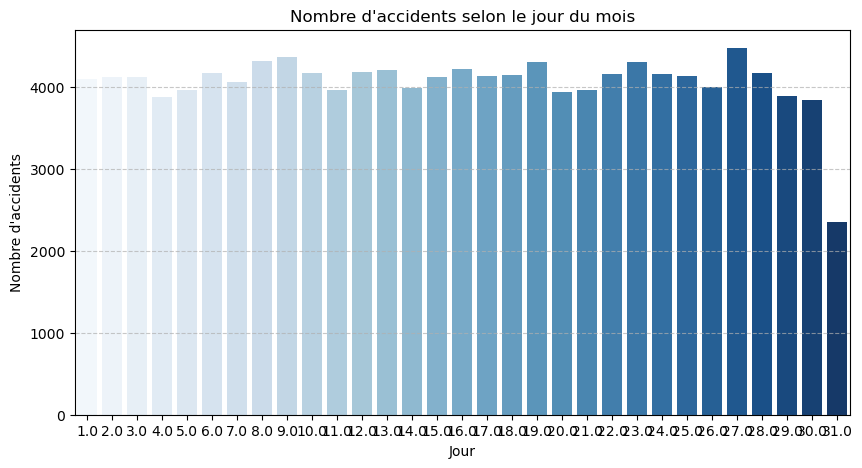

In [275]:
# Comptage des accidents par jour
accidents_par_jour = base_finale['jour'].value_counts().sort_index()
# Graphique des accidents par jour
plt.figure(figsize=(10, 5))
sns.barplot(x=accidents_par_jour.index, y=accidents_par_jour.values, palette="Blues")
plt.title("Nombre d'accidents selon le jour du mois")
plt.xlabel("Jour")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_16832\920726768.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_mois.index, y=accidents_par_mois.values, palette="Reds")


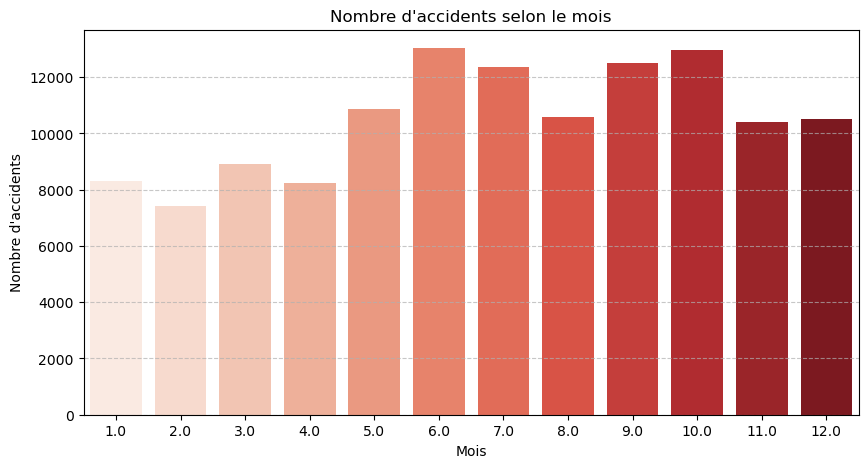

In [276]:
# Comptage des accidents par mois
accidents_par_mois = base_finale['mois'].value_counts().sort_index()
# Graphique des accidents par mois
plt.figure(figsize=(10, 5))
sns.barplot(x=accidents_par_mois.index, y=accidents_par_mois.values, palette="Reds")
plt.title("Nombre d'accidents selon le mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Distribution spatiale : par commune (com) et département (dep)

C:\Users\SCD UM\AppData\Local\Temp\ipykernel_16832\3423330474.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_commune.index, y=accidents_par_commune.values, palette="Blues")


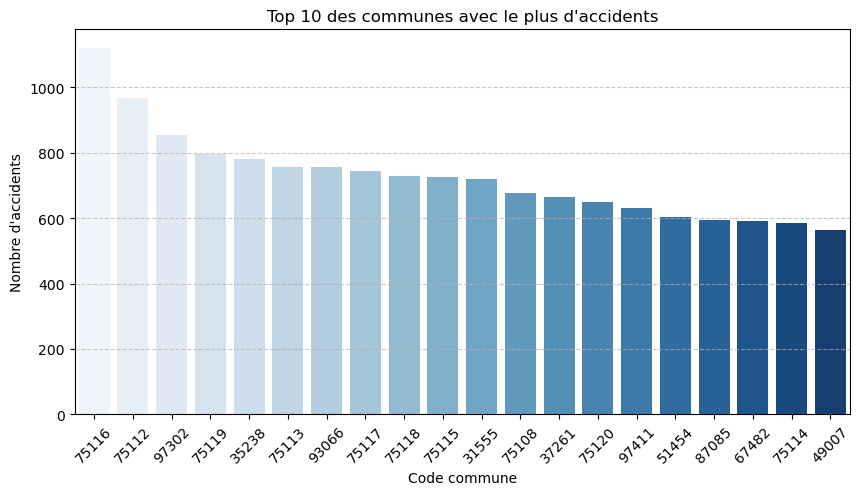

In [289]:
# Comptage des accidents par commune
accidents_par_commune = base_finale['com'].value_counts().head(20)
#print("Top 10 des communes avec le plus d'accidents :\n", accidents_par_commune)

# Graphique des accidents par commune
plt.figure(figsize=(10, 5))
sns.barplot(x=accidents_par_commune.index, y=accidents_par_commune.values, palette="Blues")
plt.title("Top 10 des communes avec le plus d'accidents")
plt.xlabel("Code commune")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\SCD UM\AppData\Local\Temp\ipykernel_16832\10050846.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_par_departement.index, y=accidents_par_departement.values, palette="Reds")


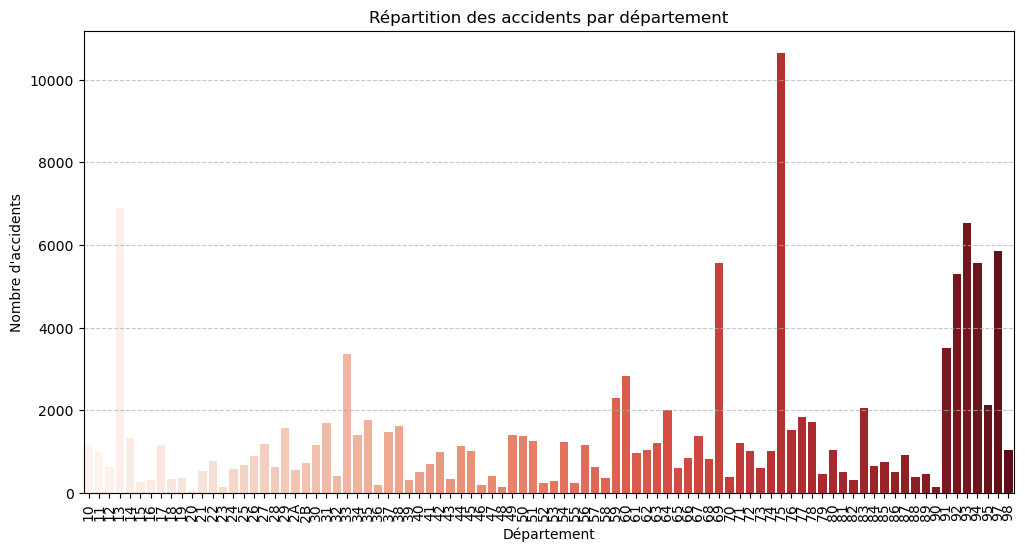

In [278]:
# Comptage des accidents par département
accidents_par_departement = base_finale['dep'].value_counts().sort_index()
#print("Répartition des accidents par département :\n", accidents_par_departement)

# Graphique des accidents par département
plt.figure(figsize=(12, 6))
sns.barplot(x=accidents_par_departement.index, y=accidents_par_departement.values, palette="Reds")
plt.title("Répartition des accidents par département")
plt.xlabel("Département")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Croisement entre gravité et catégorie d'usager

Gravité par Catégorie d’usager (%):
                     Conducteur  Passager  Piéton
grav                                            
Indemne                  83.59     15.90    0.51
Tué                      71.16     14.61   14.23
Blessé hospitalisé       69.86     16.56   13.58
Blessé léger             67.80     20.28   11.92


<Figure size 800x500 with 0 Axes>

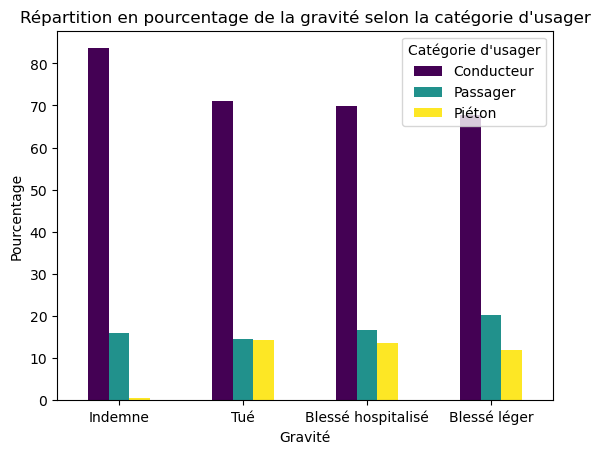

In [279]:
# Définition des labels de gravité
labels_grav = {1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"}

# Création du tableau croisé entre gravité et catégorie d'usager (en %)
cross_grav_catu = pd.crosstab(base_finale['grav'], base_finale['catu'], normalize='index') * 100
cross_grav_catu.columns = ['Conducteur', 'Passager', 'Piéton']
cross_grav_catu.index = cross_grav_catu.index.map(labels_grav)

print("Gravité par Catégorie d’usager (%):\n", cross_grav_catu.round(2))

# Création du graphique en barres empilées
plt.figure(figsize=(8, 5))
cross_grav_catu.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon la catégorie d'usager")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Catégorie d'usager")
plt.xticks(rotation=0)  # Pour une meilleure lisibilité des labels

plt.show()


### Gravité × Type de véhicule (catv)

Gravité par Type de véhicule (%):
 catv_group            -1  3 roues motorisé  Autre véhicule  EDP sans moteur  \
grav                                                                          
Indemne             0.00              0.20            0.41             0.02   
Tué                 0.00              0.47            0.06             0.09   
Blessé hospitalisé  0.01              0.65            0.44             0.20   
Blessé léger        0.00              0.95            0.44             0.39   

catv_group          EDP à moteur  Indéterminé  Moto / Scooter    PL  Quad  \
grav                                                                        
Indemne                     0.34         0.03            2.09  3.42  0.07   
Tué                         0.84         0.22           19.79  2.11  0.53   
Blessé hospitalisé          1.21         0.15           24.05  0.81  0.72   
Blessé léger                2.45         0.16           14.89  0.59  0.12   

catv_group          Spécial

<Figure size 2000x1500 with 0 Axes>

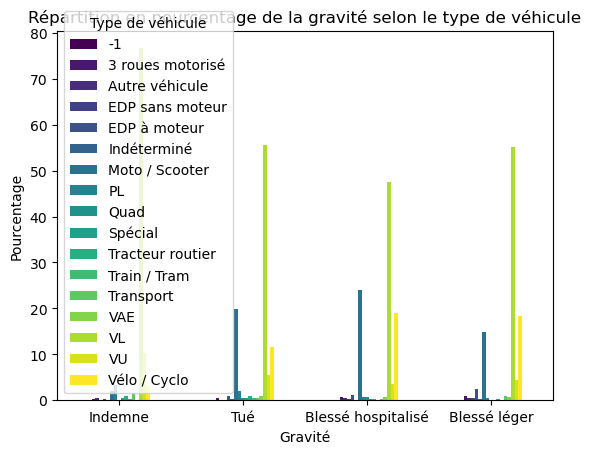

In [280]:
# Définition des labels de gravité
labels_grav = {1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"}

# Création du tableau croisé entre gravité et type de véhicule (en %)
cross_grav_catv = pd.crosstab(base_finale['grav'], base_finale['catv_group'], normalize='index') * 100
cross_grav_catv.index = cross_grav_catv.index.map(labels_grav)

print("Gravité par Type de véhicule (%):\n", cross_grav_catv.round(2))


# Création du graphique en barres empilées avec les couleurs définies
plt.figure(figsize=(20, 15))
cross_grav_catv.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon le type de véhicule")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Type de véhicule")
plt.xticks(rotation=0)  # Amélioration de la lisibilité des labels

plt.show()


Répartition de la gravité selon le type de véhicule :
                   Indemne   Tué  Blessé hospitalisé  Blessé léger
catv_group                                                       
-1                  50.00  0.00               50.00          0.00
3 roues motorisé    14.42  2.04               16.87         66.67
Autre véhicule      40.68  0.38               15.97         42.97
EDP sans moteur      4.76  1.19               15.08         78.97
EDP à moteur        10.35  1.59               13.53         74.53
Indéterminé         13.24  5.15               21.32         60.29
Moto / Scooter       7.77  4.55               32.75         54.93
PL                  77.13  2.94                6.67         13.25
Quad                14.68  6.75               54.37         24.21
Spécial             65.81  3.98               14.29         15.93
Tracteur routier    73.44  4.59                8.21         13.77
Train / Tram        60.46  6.08                7.98         25.48
Transport           5

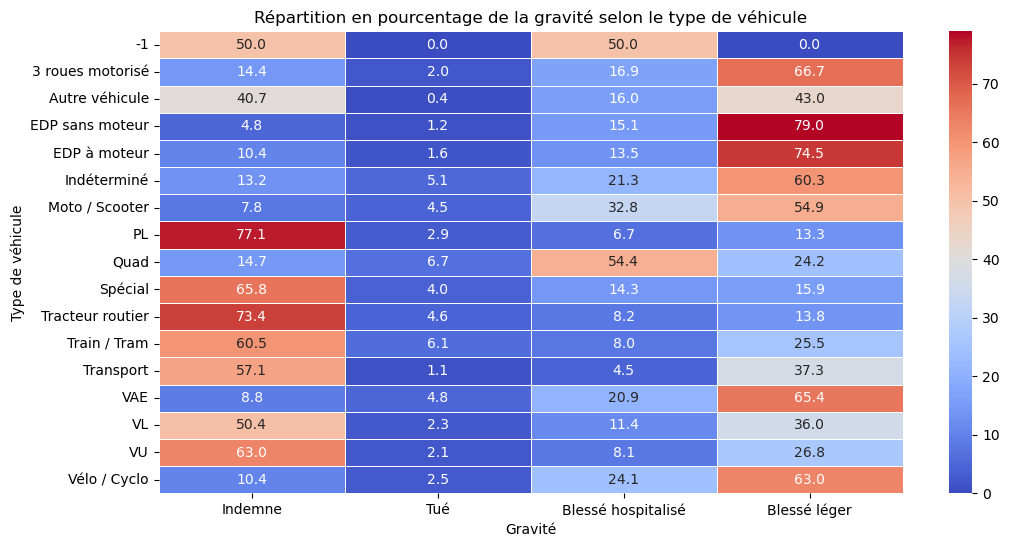

In [291]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Table croisée gravité × type de véhicule
gravite_catv = pd.crosstab(base_finale['catv_group'], base_finale['grav'], normalize='index') * 100
gravite_catv.columns = ["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"]

print("Répartition de la gravité selon le type de véhicule :\n", gravite_catv.round(2))

# Création d'une heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(gravite_catv, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)

plt.title("Répartition en pourcentage de la gravité selon le type de véhicule")
plt.xlabel("Gravité")
plt.ylabel("Type de véhicule")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


### Gravité × Conditions de lumière (lum) et météo (atm)

In [281]:
# Définition des labels de gravité
labels_grav = {1: "Indemne",2: "Tué",3: "Blessé hospitalisé",4: "Blessé léger"}

# Labels pour les conditions de lumière
labels_lum = {1: "Plein jour",2: "Crépuscule ou aube",3: "Nuit sans éclairage public",4: "Nuit avec éclairage public non allumé",
    5: "Nuit avec éclairage public allumé"}

# Labels pour les conditions météo
labels_atm = {-1: "Non renseigné",1: "Normale",2: "Pluie légère",3: "Pluie forte",4: "Neige - grêle",5: "Brouillard - fumée",
    6: "Vent fort - tempête",7: "Temps éblouissant",8: "Temps couvert",9: "Autre"
}

Gravité × Conditions de lumière (%):
                     Plein jour  Crépuscule ou aube  \
grav                                                 
Indemne                  72.40                6.33   
Tué                      58.89                7.43   
Blessé hospitalisé       67.59                7.48   
Blessé léger             68.69                6.29   

                    Nuit sans éclairage public  \
grav                                             
Indemne                                   7.32   
Tué                                      22.72   
Blessé hospitalisé                       13.12   
Blessé léger                              8.45   

                    Nuit avec éclairage public non allumé  \
grav                                                        
Indemne                                              0.70   
Tué                                                  1.18   
Blessé hospitalisé                                   0.77   
Blessé léger                   

<Figure size 1000x600 with 0 Axes>

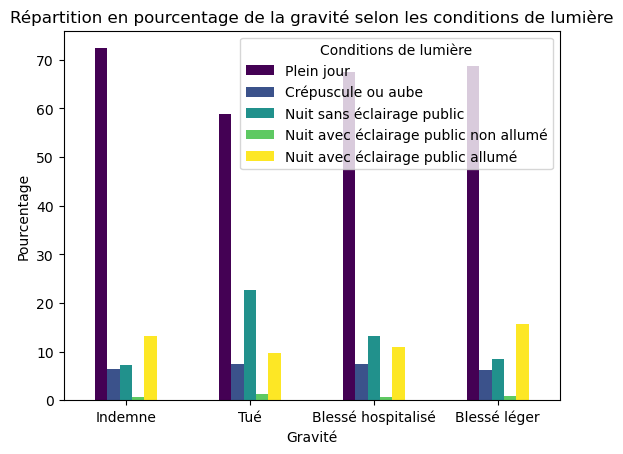

In [282]:
# Gravité × Conditions de lumière
cross_grav_lum = pd.crosstab(base_finale['grav'], base_finale['lum'], normalize='index') * 100
cross_grav_lum.index = cross_grav_lum.index.map(labels_grav)
cross_grav_lum.columns = [labels_lum.get(col, f"Inconnu ({col})") for col in cross_grav_lum.columns]

print("Gravité × Conditions de lumière (%):\n", cross_grav_lum.round(2))

# Graphique en barres empilées pour la lumière
plt.figure(figsize=(10, 6))
cross_grav_lum.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon les conditions de lumière")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Conditions de lumière")
plt.xticks(rotation=0)

plt.show()

Gravité × Conditions météo (%):
                     Non renseigné  Normale  Pluie légère  Pluie forte  \
grav                                                                    
Indemne                      0.01    80.10         10.41         2.08   
Tué                          0.06    77.72          9.38         2.05   
Blessé hospitalisé           0.01    80.54          8.69         2.05   
Blessé léger                 0.01    79.10         11.59         2.06   

                    Neige - grêle  Brouillard - fumée  Vent fort - tempête  \
grav                                                                         
Indemne                      0.52                0.58                 0.17   
Tué                          0.44                1.86                 0.40   
Blessé hospitalisé           0.54                1.00                 0.35   
Blessé léger                 0.47                0.64                 0.16   

                    Temps éblouissant  Temps couvert  Autre

<Figure size 1000x600 with 0 Axes>

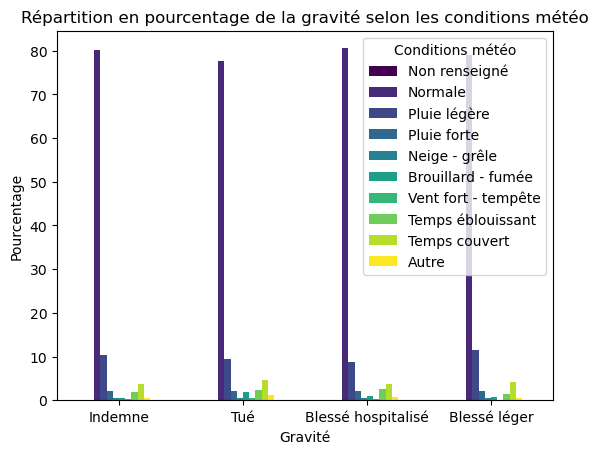

In [283]:
# Gravité × Conditions météo
cross_grav_atm = pd.crosstab(base_finale['grav'], base_finale['atm'], normalize='index') * 100
cross_grav_atm.index = cross_grav_atm.index.map(labels_grav)
cross_grav_atm.columns = [labels_atm.get(col, f"Inconnu ({col})") for col in cross_grav_atm.columns]

print("Gravité × Conditions météo (%):\n", cross_grav_atm.round(2))

# Graphique en barres empilées pour la météo
plt.figure(figsize=(10, 6))
cross_grav_atm.plot(kind='bar', stacked=False, colormap='viridis')

plt.title("Répartition en pourcentage de la gravité selon les conditions météo")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Conditions météo")
plt.xticks(rotation=0)

plt.show()



### Gravité × Port des équipements de sécurité

In [284]:
# Labels pour les équipements de sécurité
labels_secu = {
    0: "Aucun équipement",1: "Ceinture",2: "Casque",3: "Dispositif enfants",
     4: "Gilet réfléchissant",5: "Airbag",6: "Gants",7: "Gants + Airbag",
     8: "Non renseigné", 9: "Autre"
}


Gravité et Équipement 1 (%):
                     Aucun équipement  Ceinture  Casque  Dispositif enfants  \
grav                                                                         
Indemne                         1.49     84.44    4.03                0.79   
Tué                            25.79     34.74   25.73                0.40   
Blessé hospitalisé             18.89     32.96   36.77                0.31   
Blessé léger                   12.79     46.98   27.09                0.65   

                    Gilet réfléchissant  Airbag  Gants  Gants + Airbag  \
grav                                                                     
Indemne                            0.02    0.01   0.02            0.00   
Tué                                0.19    0.06   0.34            0.00   
Blessé hospitalisé                 0.18    0.05   0.38            0.00   
Blessé léger                       0.04    0.01   0.04            0.01   

                    Non renseigné  Autre  
grav         

<Figure size 1500x800 with 0 Axes>

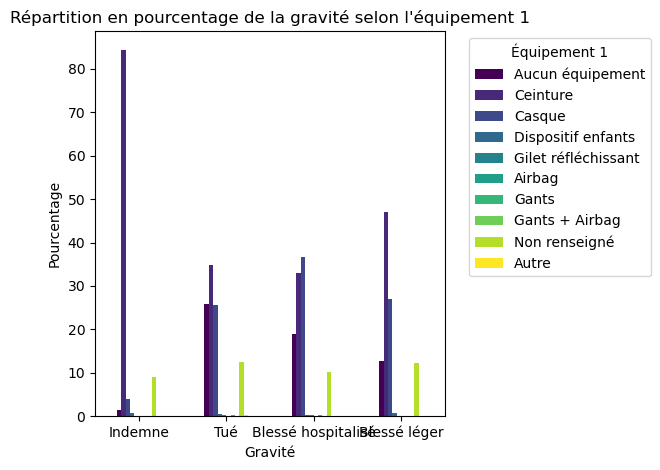

In [285]:

# Création du tableau croisé
cross_grav_secu1 = pd.crosstab(base_finale['grav'], base_finale['secu1'], normalize='index') * 100
cross_grav_secu1.index = cross_grav_secu1.index.map(labels_grav)
cross_grav_secu1.columns = [labels_secu.get(col, f"Inconnu ({col})") for col in cross_grav_secu1.columns]

print("Gravité et Équipement 1 (%):\n", cross_grav_secu1.round(2))

# Graphique
plt.figure(figsize=(15, 8))
cross_grav_secu1.plot(kind='bar', stacked=False, colormap='viridis')
plt.title("Répartition en pourcentage de la gravité selon l'équipement 1")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Équipement 1", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Gravité selon Équipement 2 (%):
                     Aucun équipement  Ceinture  Casque  Dispositif enfants  \
grav                                                                         
Indemne                        45.88      0.26    0.02                0.15   
Tué                            11.06      0.12    0.31                0.06   
Blessé hospitalisé             13.27      0.17    0.34                0.13   
Blessé léger                   37.32      0.15    0.08                0.08   

                    Gilet réfléchissant  Airbag  Gants  Gants + Airbag  \
grav                                                                     
Indemne                            1.49    1.11   2.11            0.05   
Tué                                0.19    0.81  12.43            0.19   
Blessé hospitalisé                 0.34    1.05  18.78            0.25   
Blessé léger                       1.04    1.40  12.71            0.12   

                    Non renseigné  Autre  
grav      

<Figure size 1000x600 with 0 Axes>

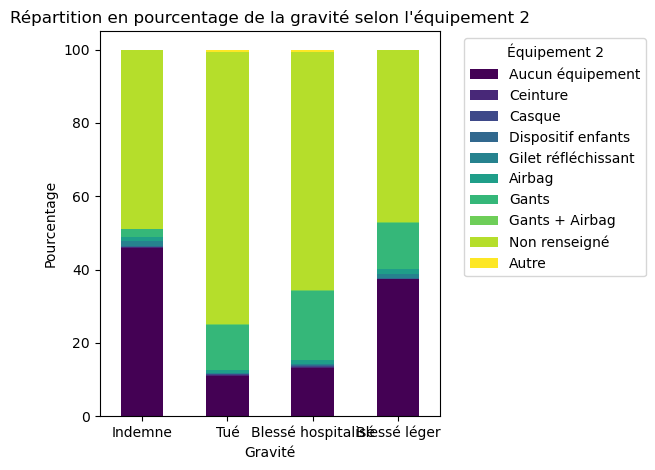

In [286]:
cross_grav_secu2 = pd.crosstab(base_finale['grav'], base_finale['secu2'], normalize='index') * 100
cross_grav_secu2.index = cross_grav_secu2.index.map(labels_grav)
cross_grav_secu2.columns = [labels_secu.get(col, f"Inconnu ({col})") for col in cross_grav_secu2.columns]

print("Gravité selon Équipement 2 (%):\n", cross_grav_secu2.round(2))

plt.figure(figsize=(10, 6))
cross_grav_secu2.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Répartition en pourcentage de la gravité selon l'équipement 2")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Équipement 2", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Gravité × Équipement 3 (%):
                     Aucun équipement  Casque  Gilet réfléchissant  Airbag  \
grav                                                                        
Indemne                         0.22    0.00                 0.00    0.01   
Tué                             0.19    0.00                 0.00    0.00   
Blessé hospitalisé              0.26    0.01                 0.06    0.01   
Blessé léger                    0.20    0.00                 0.01    0.00   

                    Gants  Gants + Airbag  Non renseigné  Autre  
grav                                                             
Indemne              0.01            0.00          99.68   0.08  
Tué                  0.22            0.00          97.27   2.33  
Blessé hospitalisé   0.23            0.01          96.54   2.89  
Blessé léger         0.04            0.01          99.28   0.46  


<Figure size 1000x600 with 0 Axes>

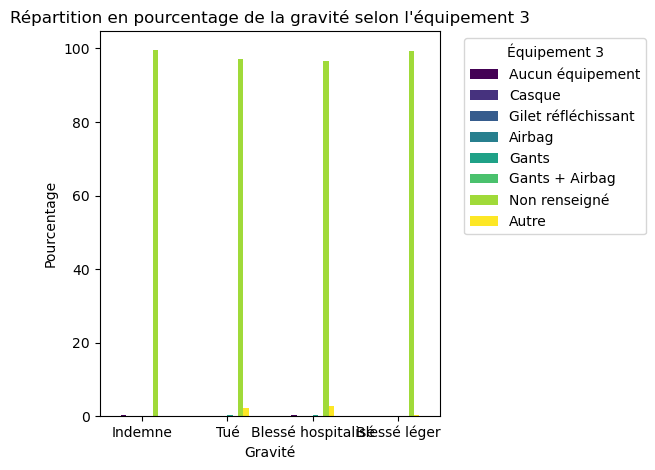

In [287]:
cross_grav_secu3 = pd.crosstab(base_finale['grav'], base_finale['secu3'], normalize='index') * 100
cross_grav_secu3.index = cross_grav_secu3.index.map(labels_grav)
cross_grav_secu3.columns = [labels_secu.get(col, f"Inconnu ({col})") for col in cross_grav_secu3.columns]

print("Gravité × Équipement 3 (%):\n", cross_grav_secu3.round(2))

plt.figure(figsize=(10, 6))
cross_grav_secu3.plot(kind='bar', stacked=False, colormap='viridis')
plt.title("Répartition en pourcentage de la gravité selon l'équipement 3")
plt.xlabel("Gravité")
plt.ylabel("Pourcentage")
plt.legend(title="Équipement 3", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [288]:
base_finale.secu1.value_counts()

secu1
1    75675
2    23944
8    13483
0    11825
3      821
6      114
9      109
4       75
5       24
7        3
Name: count, dtype: int64